pip install scikit-learn

to download the dataset http://host.robots.ox.ac.uk/pascal/VOC/voc2012/#data 

In [1]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import Image,display

import sys,os
from sklearn.utils import shuffle

In [2]:
Data_path = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/"

In [3]:
def get_data():
    
    trainX,trainY = [],[]
    
    txt_fname = Data_path+'ImageSets/Segmentation/train.txt'
    with open(txt_fname, 'r') as f:
        train_data_files = f.read().split()
        
    count=0
    for train_image in train_data_files:
        
        trainX.append(image.img_to_array(image.load_img(Data_path+"JPEGImages/"+train_image+".jpg", target_size=(320, 320)))/255)
        trainY.append(image.img_to_array(image.load_img(Data_path+"SegmentationClass/"+train_image+".png", target_size=(320, 320))))
        count = count+1
        if count >100:
            break
    return np.array(trainX),np.array(trainY)

In [4]:
trainX,trainY = get_data()
print(trainX.shape , trainY.shape)

(101, 320, 320, 3) (101, 320, 320, 3)


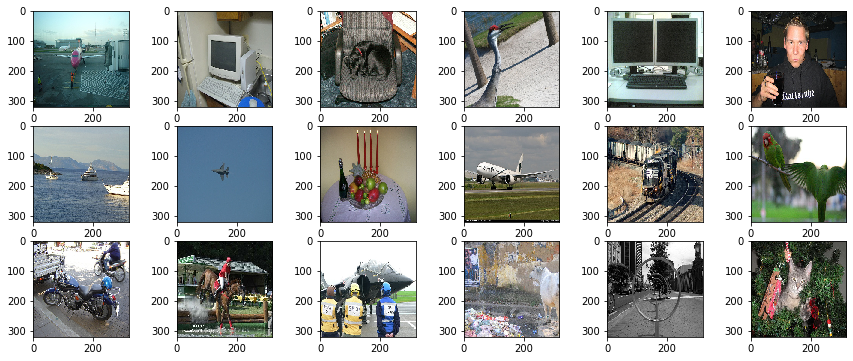

In [5]:
fig=plt.figure(figsize=(15, 6))
columns = 6
rows = 3
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(trainX[i])
plt.show()

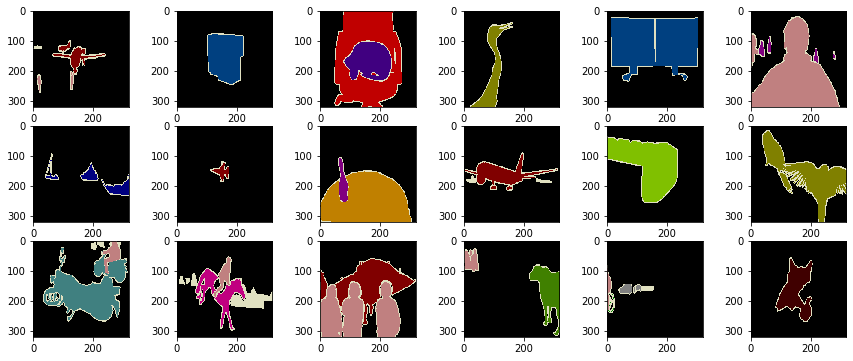

In [6]:
fig=plt.figure(figsize=(15, 6))
columns = 6
rows = 3
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(trainY[i]/255)
plt.show()

In [7]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']


In [8]:
colormap2label = np.zeros(256 ** 3)
for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

# This function has been saved in the d2l package for future use
def voc_label_indices(colormap, colormap2label):
    colormap = colormap.astype('int32')
    idx = ((colormap[:,:, :, 0] * 256 + colormap[:,:, :, 1]) * 256
           + colormap[:,:, :, 2])
    return colormap2label[idx]

trainY = voc_label_indices(trainY, colormap2label) #each pixel has the class id 0-20

In [9]:
trainY.shape

(101, 320, 320)

In [10]:
reshape_y = trainY.reshape((101,-1))
reshape_y = reshape_y.astype(int)
print(reshape_y.shape)

(101, 102400)


In [11]:
trainY_one_hot_targets = np.eye(21)[reshape_y]
trainY_one_hot_targets =trainY_one_hot_targets.reshape((101,320,320,21))

In [12]:
print(trainX.shape,trainY_one_hot_targets.shape)

(101, 320, 320, 3) (101, 320, 320, 21)


In [13]:
num_epoch = 100
init_lr = 0.01
batch_size = 10

In [14]:
np.random.seed(678)
tf.set_random_seed(5678)

def tf_relu(x): return tf.nn.relu(x)
def d_tf_relu(s): return tf.cast(tf.greater(s,0),dtype=tf.float32)
def tf_softmax(x): return tf.nn.softmax(x)
def np_sigmoid(x): 1/(1 + np.exp(-1 *x))

In [15]:
class downsampling_layer_conv():
    
    def __init__(self,kernal_size,channels,no_of_filters):
        self.w = tf.Variable(tf.random_normal([kernal_size,kernal_size,channels,no_of_filters],stddev=0.05))

    def append_layer(self,input,stride=1,dilate=1,last= False):
        self.input  = input
        
        if last:
            self.layer  = tf.nn.relu(tf.nn.conv2d(input,self.w,strides = [1,stride,stride,1],padding='SAME'))
        else:
            self.layer  = tf.nn.conv2d(input,self.w,strides = [1,stride,stride,1],padding='SAME')
            
        return self.layer

class upsampling_layer_deconv():
    
    def __init__(self,kernal_size,channels,no_of_filters):
        self.w = tf.Variable(tf.random_normal([kernal_size,kernal_size,channels,no_of_filters],stddev=0.05))
        
    def append_layer(self,input,stride=1,dilate=1,output=1):
        self.input  = input

        current_shape_size = input.shape
        output_shape = [batch_size] + [int(current_shape_size[1].value*2),int(current_shape_size[2].value*2),int(current_shape_size[3].value/2)]
        
        self.layer = tf.nn.conv2d_transpose(input,self.w,output_shape=output_shape,strides=[1,2,2,1],padding='SAME')
        self.layerA = tf.nn.relu(self.layer)
        return self.layerA

In [16]:
# left
l1_1 = downsampling_layer_conv(3,3,3) # 320-3+1 
l1_2 = downsampling_layer_conv(3,3,3)
l1_3 = downsampling_layer_conv(3,3,3)

l2_1 = downsampling_layer_conv(3,3,6)
l2_2 = downsampling_layer_conv(3,6,6)
l2_3 = downsampling_layer_conv(3,6,6)

l3_1 = downsampling_layer_conv(3,6,12)
l3_2 = downsampling_layer_conv(3,12,12)
l3_3 = downsampling_layer_conv(3,12,12)

l4_1 = downsampling_layer_conv(3,12,24)
l4_2 = downsampling_layer_conv(3,24,24)
l4_3 = downsampling_layer_conv(3,24,24)

l5_1 = downsampling_layer_conv(3,24,48)
l5_2 = downsampling_layer_conv(3,48,48)
l5_3 = downsampling_layer_conv(3,48,24)

# right
l6_1 = upsampling_layer_deconv(3,24,48)
l6_2 = downsampling_layer_conv(3,24,24)
l6_3 = downsampling_layer_conv(3,24,12)

l7_1 = upsampling_layer_deconv(3,12,24)
l7_2 = downsampling_layer_conv(3,12,12)
l7_3 = downsampling_layer_conv(3,12,6)

l8_1 = upsampling_layer_deconv(3,6,12)
l8_2 = downsampling_layer_conv(3,6,6)
l8_3 = downsampling_layer_conv(3,6,3)

l9_1 = upsampling_layer_deconv(3,3,6)
l9_2 = downsampling_layer_conv(3,3,3)
l9_3 = downsampling_layer_conv(3,3,3)

l10_final = downsampling_layer_conv(3,3,21)

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
x = tf.placeholder(shape=[None,320,320,3],dtype=tf.float32)
y = tf.placeholder(shape=[None,320,320,21],dtype=tf.float32)

In [18]:

layer1_1 = l1_1.append_layer(x)
layer1_2 = l1_2.append_layer(layer1_1)
layer1_3 = l1_3.append_layer(layer1_2)

layer2_Input = tf.nn.max_pool(layer1_3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
layer2_1 = l2_1.append_layer(layer2_Input)
layer2_2 = l2_2.append_layer(layer2_1)
layer2_3 = l2_3.append_layer(layer2_2)

layer3_Input = tf.nn.max_pool(layer2_3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
layer3_1 = l3_1.append_layer(layer3_Input)
layer3_2 = l3_2.append_layer(layer3_1)
layer3_3 = l3_3.append_layer(layer3_2)

layer4_Input = tf.nn.max_pool(layer3_3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
layer4_1 = l4_1.append_layer(layer4_Input)
layer4_2 = l4_2.append_layer(layer4_1)
layer4_3 = l4_3.append_layer(layer4_2)

layer5_Input = tf.nn.max_pool(layer4_3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
layer5_1 = l5_1.append_layer(layer5_Input)
layer5_2 = l5_2.append_layer(layer5_1)
layer5_3 = l5_3.append_layer(layer5_2)

layer6_Input = tf.concat([layer5_3,layer5_Input],axis=3)
layer6_1 = l6_1.append_layer(layer6_Input)
layer6_2 = l6_2.append_layer(layer6_1)
layer6_3 = l6_3.append_layer(layer6_2)

layer7_Input = tf.concat([layer6_3,layer4_Input],axis=3)
layer7_1 = l7_1.append_layer(layer7_Input)
layer7_2 = l7_2.append_layer(layer7_1)
layer7_3 = l7_3.append_layer(layer7_2)

layer8_Input = tf.concat([layer7_3,layer3_Input],axis=3)
layer8_1 = l8_1.append_layer(layer8_Input)
layer8_2 = l8_2.append_layer(layer8_1)
layer8_3 = l8_3.append_layer(layer8_2)

layer9_Input = tf.concat([layer8_3,layer2_Input],axis=3)
layer9_1 = l9_1.append_layer(layer9_Input)
layer9_2 = l9_2.append_layer(layer9_1)
layer9_3 = l9_3.append_layer(layer9_2,last=True)

layer10 = l10_final.append_layer(layer9_3,last = True)

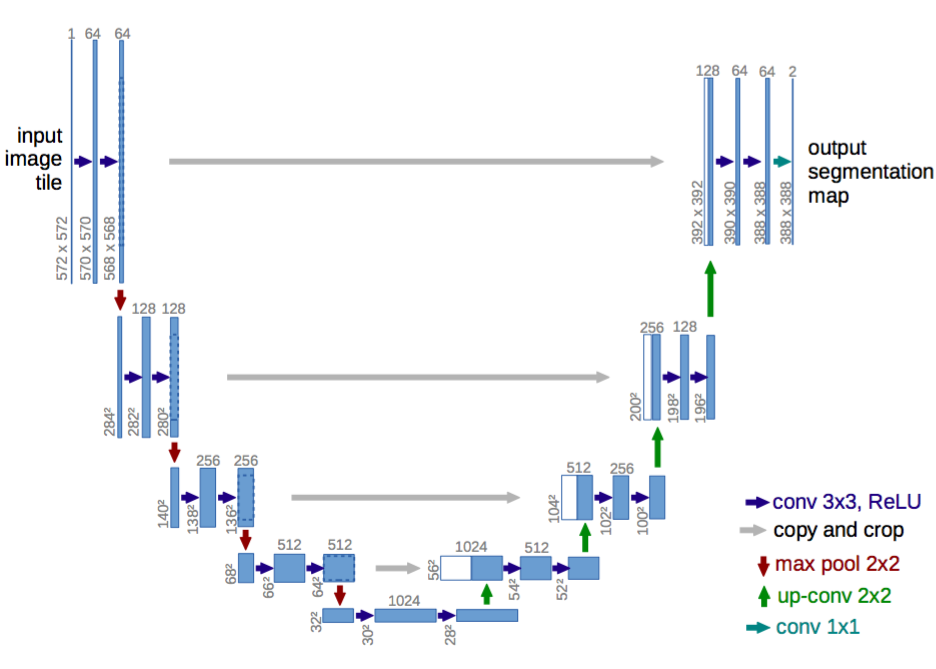

In [22]:
display(Image("unet.png"))

In [19]:
# cost = tf.reduce_mean(tf.square(layer10-y))
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer10, labels=y))
auto_train = tf.train.AdamOptimizer(learning_rate=init_lr).minimize(cost)

In [21]:
# --- start session ---
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for iter in range(num_epoch):
        
        # train
        for current_batch_index in range(0,len(trainX),batch_size):
            current_batch = trainX[current_batch_index:current_batch_index+batch_size,:,:,:]
            current_label = trainY_one_hot_targets[current_batch_index:current_batch_index+batch_size,:,:,:]
            sess_results,_ = sess.run([cost,auto_train],feed_dict={x:current_batch,y:current_label})
            print(' Iter: ', iter, " Cost:  %.32f"% sess_results)
        print('\n-----------------------')
#         train_images,train_labels = shuffle(train_images,train_labels)

 Iter:  0  Cost:  3.04450058937072753906250000000000
 Iter:  0  Cost:  3.04442453384399414062500000000000
 Iter:  0  Cost:  3.04351258277893066406250000000000
 Iter:  0  Cost:  3.03791332244873046875000000000000
 Iter:  0  Cost:  3.01815032958984375000000000000000
 Iter:  0  Cost:  2.94450283050537109375000000000000
 Iter:  0  Cost:  2.76626515388488769531250000000000
 Iter:  0  Cost:  1.83392000198364257812500000000000


KeyboardInterrupt: 

In [ ]:
For deeplab image segmentation

https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb